In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/"
EXTRACT_PATH = "/content/data/"
ZIP_FILE_PATH = os.path.join(DRIVE_PROJECT_PATH, "final_dataset_2.zip")

with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    # We extract to /content/data/ which will create /content/data/04_Processed_Data/
    zip_ref.extractall(EXTRACT_PATH)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import glob
import librosa
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:

data_path = f"{EXTRACT_PATH}/final_dataset_2"
KEY_RANGE_START = 21; KEY_RANGE_END = 108;
NOTE_NAMES_SHARP = ['C', 'Cs', 'D', 'Ds', 'E', 'F', 'Fs', 'G', 'Gs', 'A', 'As', 'B']
CHORD_STRUCTURES = {
    'major_triad': [0, 4, 7], 'minor_triad': [0, 3, 7],
    'diminished_triad': [0, 3, 6], 'augmented_triad': [0, 4, 8],
    'dominant_7th': [0, 4, 7, 10], 'major_7th': [0, 4, 7, 11],
    'minor_7th': [0, 3, 7, 10],
}
SAMPLE_RATE = 44100

In [ ]:
data = glob.glob(f"{data_path}/*.npz")
len(data)

266574

In [ ]:
# data_test = []
# def get_test_data(whole_data):
#   for sample in whole_data:
#     sample_array = np.load(sample)
#     mel_array = sample_array["mel"]
#     label_array = sample_array["label"]
#     if sum(label_array[:1]) ==1 and sum(label_array[1:])==0:
#       data_test.append(sample)
# get_test_data(data[:186601])
# data_test

['/content/data//final_dataset_2/audio_sample29283-0.npz',
 '/content/data//final_dataset_2/audio_sample3872-0.npz',
 '/content/data//final_dataset_2/audio_sample8164-4.npz',
 '/content/data//final_dataset_2/audio_sample29284-1.npz',
 '/content/data//final_dataset_2/audio_sample12387-6.npz',
 '/content/data//final_dataset_2/audio_sample16613-2.npz',
 '/content/data//final_dataset_2/audio_sample8164-3.npz',
 '/content/data//final_dataset_2/audio_sample8165-6.npz',
 '/content/data//final_dataset_2/audio_sample29282-1.npz',
 '/content/data//final_dataset_2/audio_sample25061-4.npz',
 '/content/data//final_dataset_2/audio_sample33508-2.npz',
 '/content/data//final_dataset_2/audio_sample16612-1.npz',
 '/content/data//final_dataset_2/audio_sample29283-4.npz',
 '/content/data//final_dataset_2/audio_sample16611-3.npz',
 '/content/data//final_dataset_2/audio_sample33506-0.npz',
 '/content/data//final_dataset_2/audio_sample20836-5.npz',
 '/content/data//final_dataset_2/audio_sample29284-6.npz',
 

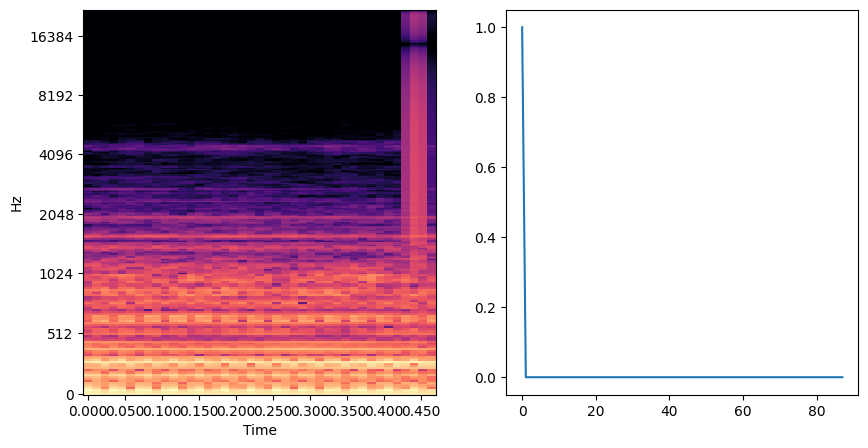

In [ ]:
random_sample = random.choice(data_test)
sample_data = np.load(random_sample)
mel = sample_data["mel"]
label = sample_data["label"]


plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
librosa.display.specshow(mel,sr=SAMPLE_RATE, x_axis='time', y_axis='mel')

plt.subplot(1,2,2)
plt.plot(label)
plt.show()


In [ ]:
train_df, eval_df = train_test_split(data,test_size = 0.3,random_state=42)
val_df,test_df = train_test_split(eval_df,test_size = 0.25,random_state=42)

print(f"train size {len(train_df)}")
print(f"validation size {len(val_df)}")
print(f"test size {len(test_df)}")

train size 186601
validation size 59979
test size 19994


In [ ]:
class DataGenerator(Sequence):

    def __init__(self,audio_data,batch_size=32,shuffle=True):
        self.audio_data = audio_data
        self.batch_size = batch_size
        self.shuffle = shuffle


    def __getitem__(self,index):
        current_batch = self.audio_data[index*self.batch_size : min((index+1)*self.batch_size, len(self.audio_data))]

        X,y=[],[]
        for batch_ in current_batch:
            mel_,lab_ = self.decode_data(batch_)
            X.append(mel_)
            y.append(lab_)
        return np.array(X),np.array(y)



    def __len__(self):
        return int(np.ceil(len(self.audio_data) / self.batch_size))


    def on_epoch_end(self):
        if self.shuffle:
          random.shuffle(self.audio_data)


    def decode_data(self,data_file):
        sample_array = np.load(data_file)
        mel_array = sample_array["mel"]
        label_array = sample_array["label"]
        # return np.repeat(mel_array[..., np.newaxis], 3, axis=-1),label_array
        return mel_array[..., np.newaxis], label_array


In [ ]:
train_gen = DataGenerator(train_df)
val_gen = DataGenerator(val_df)
test_gen = DataGenerator(test_df,shuffle=False)

In [ ]:
mel.shape

(256, 41)

In [ ]:
input_shape = train_gen[0][0].shape[1:]
input_shape

(256, 41, 1)

In [ ]:
# del model

In [ ]:
# base_model = VGG16(
#     weights='imagenet',
#     include_top=False,
#     input_shape=input_shape
# )
# base_model.trainable = False  # Freeze for feature extraction

# # Add your custom classifier head for 88-key multi-label output
# model = Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(88, activation='sigmoid')  # 88 keys, multi-label
# ])
# model.summary()

In [ ]:
from tensorflow.keras import layers, Input, Model

input_shape = (256, 41, 1) # Assuming (frequency, time, channels)
inputs = Input(shape=input_shape)

# --- CNN Feature Extractor ---
# Block 1
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 2
x = layers.Conv2D(64, (3, 7), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 4
x = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)


# --- Bridge to RNN ---
# We want to treat the time dimension as the sequence for the LSTM.
# The current shape has the time dimension as axis 2: (batch, freq, time, chan)
# Final CNN output shape: (None, 16, 2, 256)


shape = x.shape

x = layers.Reshape((shape[2], shape[1] * shape[3]))(x)


# --- RNN Layer ---
# Bidirectional is often better for this task
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x) # (batch, 256)

# --- Classification Head ---
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(88, activation='sigmoid')(x)  # For 88-note multi-label

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 41, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 41, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 41, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 20, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 20, 64)    │        43,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 20, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 5, 256)     │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 5, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 2, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 2, 4096)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │     4,326,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 88)             │        45,144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,754,136 (18.14 MB)

 Trainable params: 4,753,176 (18.13 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# model = Sequential([
#      layers.InputLayer(input_shape=input_shape),

#     # Block 1
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),

#     # # Block 2
#     # layers.Conv2D(64, (5,5), activation='relu', padding='same'),
#     # layers.BatchNormalization(),
#     # layers.MaxPooling2D((2, 2)),

#     # # Block 3
#     # layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
#     # layers.BatchNormalization(),
#     # layers.MaxPooling2D((2, 2)),

#     # # Block 4 (New) - To learn more complex features
#     # layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     # layers.BatchNormalization(),
#     # layers.MaxPooling2D((2, 2)),

#     layers.Flatten(),

#     # Dense layers for classification
#     layers.Dense(1024, activation='relu'),
#     # layers.Dropout(0.5),

#     # Output Layer
#     layers.Dense(88, activation='sigmoid')
# ])
# model.summary()

In [ ]:
import keras.backend as K

#from gemini to improve recall

def focal_loss(gamma=2.0, alpha=0.25):


    """
    A more complete and robust implementation of Focal Loss.
    `alpha` controls the weighting for the positive class.
    `gamma` controls the focusing parameter.
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)

        # Calculate the loss for the positive class (y_true == 1)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        loss_1 = -alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)

        # Calculate the loss for the negative class (y_true == 0)
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss_0 = -(1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0)

        # Sum the losses
        loss = loss_1 + loss_0
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

    return focal_loss_fixed

In [ ]:
model.compile(
    optimizer='adam',
    # loss='binary_crossentropy',
    loss=focal_loss(gamma=2.0, alpha=0.35),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_recall',      # or use 'val_AUC' for note detection
        patience=7,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_recall',
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_recall',
        factor=0.01,
        patience=5
    ),
]

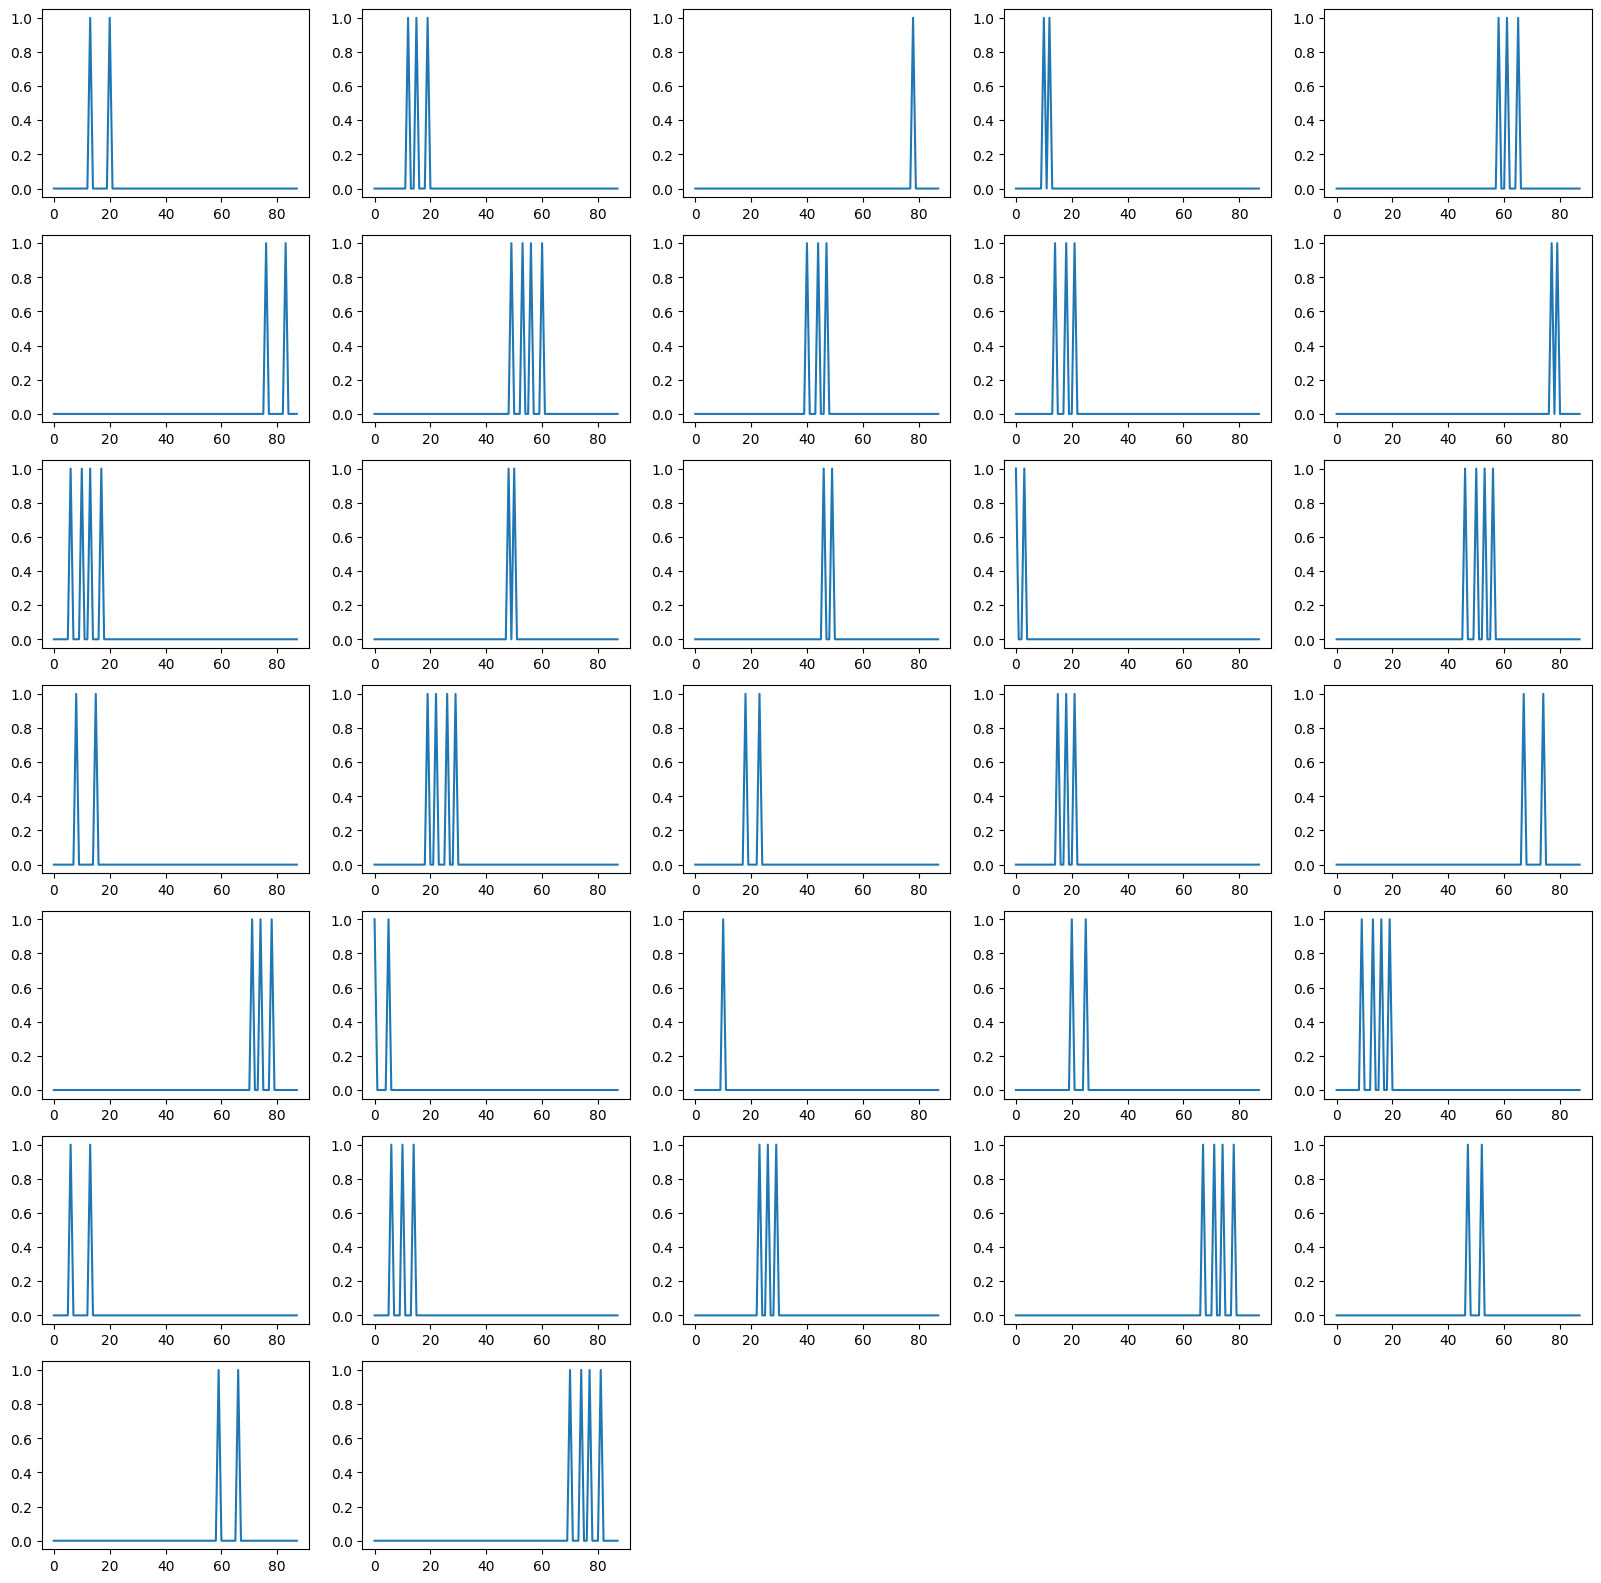

In [ ]:
mel_samples,label_sample = train_gen[0]

num_row =  len(label_sample)//5

plt.figure(figsize=(20,20))
for row_index,sample_label in enumerate(label_sample):

  plt.subplot(num_row+1,5,row_index+1)
  plt.plot(sample_label)
plt.show()

In [ ]:
class_weights = {0: 1, 1: 5}
history = model.fit(train_gen,validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
                    # class_weight=class_weight,
    verbose=1)

Epoch 1/50
5832/5832 ━━━━━━━━━━━━━━━━━━━━ 522s 89ms/step - auc: 0.8828 - binary_accuracy: 0.9718 - loss: 1.0170 - precision: 0.6522 - recall: 0.1400 - val_auc: 0.9697 - val_binary_accuracy: 0.9816 - val_loss: 0.5773 - val_precision: 0.9676 - val_recall: 0.4049 - learning_rate: 0.0010
Epoch 2/50
1162/5832 ━━━━━━━━━━━━━━━━━━━━ 5:01 65ms/step - auc: 0.9653 - binary_accuracy: 0.9810 - loss: 0.6134 - precision: 0.9041 - recall: 0.4134